In [6]:
import logging
import os
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uxarray
import xarray
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

try:  # Avoid ValueError when assigning cmap again
    cmap = cmaps.WhiteBlueGreenYellowRed
except ValueError:
    pass

from sklearn.neighbors import BallTree as SKBallTree

In [2]:
figw = 12
projection = ccrs.LambertConformal(central_longitude=-82)

norm = mpl.colors.Normalize(vmin=0, vmax=50)


def mkcoord(ds):
    if "t_iso_levels" in ds:
        ds = ds.swap_dims(dict(nIsoLevelsT="t_iso_levels", nIsoLevelsZ="z_iso_levels"))
    return ds


def dec_ax(ax, extent):
    # ax.add_feature(cfeature.STATES)
    ax.set_extent(extent)

    gl = ax.gridlines(draw_labels=True, x_inline=False)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER


def dBZfunc(dBZ, func):
    """mean of linearized Z, not logarithmic dbZ"""
    Z = 10 ** (dBZ / 10)
    fZ = func(Z)
    return np.log10(fZ) * 10


def trim_latlon(grid_path, data_paths, extent):
    """
    trim grid file and data file to extent box
    TODO: use uxarray.Dataset.subset
    """

    # Open the Grid file
    grid_ds = xarray.open_dataset(grid_path)

    grid_ds["lonCell"] = np.degrees(grid_ds.lonCell)
    grid_ds["latCell"] = np.degrees(grid_ds.latCell)

    # before computing the triangulation
    grid_ds["lonCell"] = ((grid_ds["lonCell"] + 180) % 360) - 180

    # Open data files
    ds = xarray.open_mfdataset(
        data_paths, preprocess=mkcoord, concat_dim="Time", combine="nested"
    )

    ibox = (
        (grid_ds.lonCell >= lon0)
        & (grid_ds.lonCell < lon1)
        & (grid_ds.latCell >= lat0)
        & (grid_ds.latCell < lat1)
    )
    # Trim grid
    grid_ds = grid_ds[["latCell", "lonCell"]].where(ibox, drop=True)

    # Trim data
    ds = ds.where(ibox, drop=True)

    return grid_ds, ds

## HWT 2023 MPAS

In [3]:
idate = pd.to_datetime("20230429T00")
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_5"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
data_paths = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=3),
        end=idate + pd.Timedelta(hours=18),
        freq="3H",
    )
]
data_paths = [base_path / name for name in data_paths]

uxds = uxarray.open_mfdataset(
    grid_path, data_paths, concat_dim="Time", combine="nested", use_dual=False
)
print(uxds.source_datasets)

[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_03.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_06.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_09.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_12.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_15.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_18.00.00.nc')]


/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## Trim global mesh to lat/lon box

In [4]:
# limit to lat lon box

lat0, lat1 = 41, 42.5
lon0, lon1 = -75, -70

# lat0, lat1 = 35, 43
# lon0, lon1 = -83, -66

extent = [lon0, lon1, lat0, lat1]
grid_ds, ds = trim_latlon(grid_path, data_paths, extent)

projection = ccrs.LambertConformal(central_longitude=-82)
if lon1 - lon0 > 15:
    projection = ccrs.PlateCarree()

var = ds["refl10cm_max"].isel(Time=0).compute()

## Upscale to 30-km mesh

CPU times: user 348 ms, sys: 30.9 ms, total: 379 ms
Wall time: 1.24 s


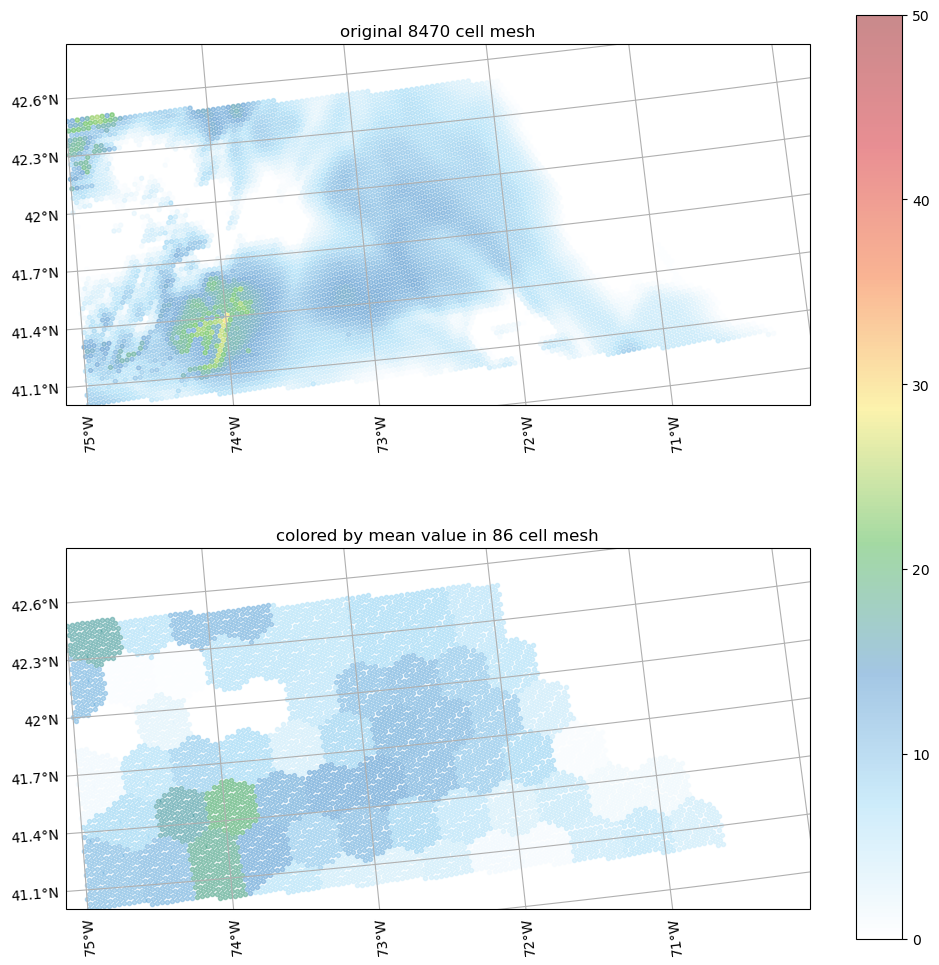

In [7]:
%%time
fig, axes = plt.subplots(
    nrows=2,
    figsize=(figw, 12),
    subplot_kw=dict(projection=projection),
)

ax = axes[0]
ax.set_title(f"original {len(grid_ds.lonCell)} cell mesh")
cc = ax.scatter(
    grid_ds["lonCell"],
    grid_ds["latCell"],
    c=var,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    marker=".",
    alpha=0.5,
)

fig.colorbar(cc, ax=axes)

tmpdir = Path(os.getenv("TMPDIR"))
# Upscale to coarse mesh
coarse_mesh = xarray.open_dataset(
    tmpdir.parents[1]
    / "nystrom/pandac/nystrom_3dvar_O30kmIE60km_ColdStart_TEST/CyclingFC/2022020100/static.655362.nc"
)
coarse_mesh["lonCell"] = np.degrees(coarse_mesh.lonCell)
coarse_mesh["latCell"] = np.degrees(coarse_mesh.latCell)
# before computing the triangulation
coarse_mesh["lonCell"] = ((coarse_mesh["lonCell"] + 180) % 360) - 180

ibox = (
    (coarse_mesh.lonCell >= lon0)
    & (coarse_mesh.lonCell < lon1)
    & (coarse_mesh.latCell >= lat0)
    & (coarse_mesh.latCell < lat1)
)
logging.info("Trim latCell and lonCell")
coarse_mesh = coarse_mesh[["latCell", "lonCell"]].where(ibox, drop=True)

X = np.c_[coarse_mesh.latCell.values.ravel(), coarse_mesh.lonCell.values.ravel()]
# List MPAS indices closest to each coarse mesh cell
idxs = SKBallTree(np.deg2rad(X), metric="haversine").query(
    np.deg2rad(np.c_[grid_ds["latCell"], grid_ds["lonCell"]]), return_distance=False
)

coarse_var = np.empty(coarse_mesh["lonCell"].shape)
coarse_var.fill(np.nan)

axes[1].set_title(f"colored by mean value in {len(coarse_mesh.lonCell)} cell mesh")

for idx in np.unique(idxs):
    i = idxs.squeeze() == [idx]
    if any(i):
        coarse_var[idx] = dBZfunc(var.values[i], np.mean)
        c = dBZfunc(var.values[i], np.mean)
        cc = axes[1].scatter(
            grid_ds["lonCell"][i],
            grid_ds["latCell"][i],
            c=[cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(c)],
            transform=ccrs.PlateCarree(),
            marker=".",
            alpha=0.5,
        )


for ax in axes:
    dec_ax(ax, extent)

coarse_mesh[var.name] = coarse_var

In [ ]:
%%time
import holoviews as hv
import hvplot.pandas

coarse_grid = uxarray.open_grid(
    tmpdir.parents[1]
    / "nystrom/pandac/nystrom_3dvar_O30kmIE60km_ColdStart_TEST/CyclingFC/2022020100/static.655362.nc"
)
downsampled_uxds = (
    uxds["refl10cm_max"]
    .isel(Time=2)
    .nearest_neighbor_remap(destination_obj=coarse_grid, remap_to="face centers")
)

In [ ]:
lon_bounds = (-75, -71)
lat_bounds = (40, 42)
gdf_original = (
    uxds["refl10cm_max"]
    .isel(Time=2)
    .subset.bounding_box(lon_bounds, lat_bounds)
    .to_geodataframe()
)
gdf_downsampled = downsampled_uxds.subset.bounding_box(
    lon_bounds, lat_bounds
).to_geodataframe()

In [ ]:
hv.extension("matplotlib")

In [ ]:
(
    gdf_original.hvplot.polygons(
        rasterize=True,
        c="refl10cm_max",
        cmap=cmap,
        geo=True,
        clim=(0, 50),
        grid=True,
        projection=projection,
        title="Original Grid",
    )
    + gdf_downsampled.hvplot.polygons(
        rasterize=True,
        c="refl10cm_max",
        cmap=cmap,
        geo=True,
        clim=(0, 50),
        grid=True,
        projection=projection,
        title="Downsampled (Nearest Neighbor)",
    )
).cols(1).opts()